In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn as skl

from pathlib import Path

from mylib import class_distributions
from mylib import helper_funcs

from mylib.my_xgb import add_class

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data_folder = data_folder = Path("../../data/DryBeanDataset/")

In [3]:
data = pd.read_csv(data_folder / 'DryBeanDataset.csv')

# need feature matrix X and labels labels for xgboost
labels = data["Class"]
X = data.drop(["Class"],axis=1,inplace=False)

In [4]:
class_distributions.label_proportions(data['Class'])

6    0.260525
5    0.193667
0    0.148924
4    0.141650
3    0.119756
1    0.097127
2    0.038351
Name: Class, dtype: float64

In [5]:
training_method = 'continued_training'
new_class_idx = 6
num_models = 10
num_round = 10
max_depth = 3

In [6]:
# create model file 
Path('models').mkdir(parents=True, exist_ok=True)
model_folder = Path("models/")

In [7]:
# prepare smaller dataset with only first num_labels classes of beans
old_classes = np.setdiff1d(labels.unique(), new_class_idx)
new_class = new_class_idx

# compute number of old labels used
num_labels = len(old_classes)

# relabel for XGBoost
labels, relabel_dict = helper_funcs.relabel(labels, old_classes, new_class)

# the "original" training data
data_small = X[labels < num_labels]
labels_small = labels[labels < num_labels]

# to check full model on all of the old data
dsmall = xgb.DMatrix(data_small, label=labels_small)

# the new class data
new_class_data = X[labels == num_labels]
new_class_labels = labels[labels == num_labels]

# only to check performance on the newly added data
dnew_class = xgb.DMatrix(new_class_data, label=new_class_labels)

# the entire training data
data_full = pd.concat([data_small, new_class_data])
labels_full = pd.concat([labels_small, new_class_labels])

# to check full model on the full data
dfull = xgb.DMatrix(data_full, label=labels_full)

# I don't have the time to vary this
num_round_update=[i for i in range(1,11)]
eta = .1

# parameters for small model
param_small = {'max_depth': max_depth,
               'eta': eta,
               'objective': 'multi:softprob',
               "num_class": num_labels}
param_small['nthread'] = 4
param_small['eval_metric'] = 'mlogloss'


# parameters for update model (the same as for full model, but just in case I want to ever change them)
param_update = {'max_depth': max_depth,
                'eta': eta,
                'objective': 'multi:softprob',
                "num_class": num_labels+1}
param_update['nthread'] = 4
param_update['eval_metric'] = 'mlogloss'

In [21]:
# these dictionaries are filled with the results and later pickled

old_data_mean_results = dict()
old_data_std_results = dict()
new_data_mean_results = dict()
new_data_std_results = dict()
full_data_mean_results = dict()
full_data_std_results = dict()

# the update routine
# initialize arrays where results are stored
old_data_mean = np.zeros(len(num_round_update))
old_data_std = np.zeros(len(num_round_update))
new_data_mean = np.zeros(len(num_round_update))
new_data_std = np.zeros(len(num_round_update))
full_data_mean = np.zeros(len(num_round_update))
full_data_std = np.zeros(len(num_round_update))

for num_round_update_idx, num_round_updt in enumerate(num_round_update):
    print(f"Current number of update rounds in use: {num_round_updt}")

    # initialize arrays where temporary results are stored
    old_data_tmp = np.zeros(num_models)
    new_data_tmp = np.zeros(num_models)
    full_data_tmp = np.zeros(num_models)

    for model_num in range(num_models):
        
        # training the original model
        
        seed = np.random.randint(0,100)
        # split original data into train- and test-data
        X_train_small, X_test_small, y_train_small, y_test_small = skl.model_selection.train_test_split(data_small, 
                                                                                                        labels_small,
                                                                                                        test_size=.2,
                                                                                                        random_state=seed)

        # specify DMatrices
        dtrain_small = xgb.DMatrix(X_train_small, label=y_train_small)
        dtest_small = xgb.DMatrix(X_test_small, label=y_test_small)
        
        evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]
        
        bst_small = xgb.train(param_small,
                              dtrain_small,
                              num_round,
                              evals=evallist_small,
                              verbose_eval=False)

        bst_small.save_model(fname=model_folder / 'small_model.json')
            
        # concatenate selected data with data of new class
        data_update = new_class_data
        labels_update = new_class_labels

        # use all the update data to update the model
        dtrain_update = xgb.DMatrix(data_update, label=labels_update)
        
        # update model
        bst_update = xgb.train(param_update,
                              dtrain_update,
                              num_round_updt,
                              verbose_eval=False,
                              xgb_model=model_folder/"small_model.json")

        
        old_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dsmall), axis=1),
                                                               labels_small)
        new_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dnew_class), axis=1),
                                                               new_class_labels)
        full_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dfull), axis=1),
                                                                labels_full)

    old_data_mean[num_round_update_idx] = old_data_tmp.mean()
    old_data_std[num_round_update_idx] = old_data_tmp.std()
    new_data_mean[num_round_update_idx] = new_data_tmp.mean()
    new_data_std[num_round_update_idx] = new_data_tmp.std()  
    full_data_mean[num_round_update_idx] = full_data_tmp.mean()
    full_data_std[num_round_update_idx] = full_data_tmp.std()

Current number of update rounds in use: 1
Current number of update rounds in use: 2
Current number of update rounds in use: 3
Current number of update rounds in use: 4
Current number of update rounds in use: 5
Current number of update rounds in use: 6
Current number of update rounds in use: 7
Current number of update rounds in use: 8
Current number of update rounds in use: 9
Current number of update rounds in use: 10


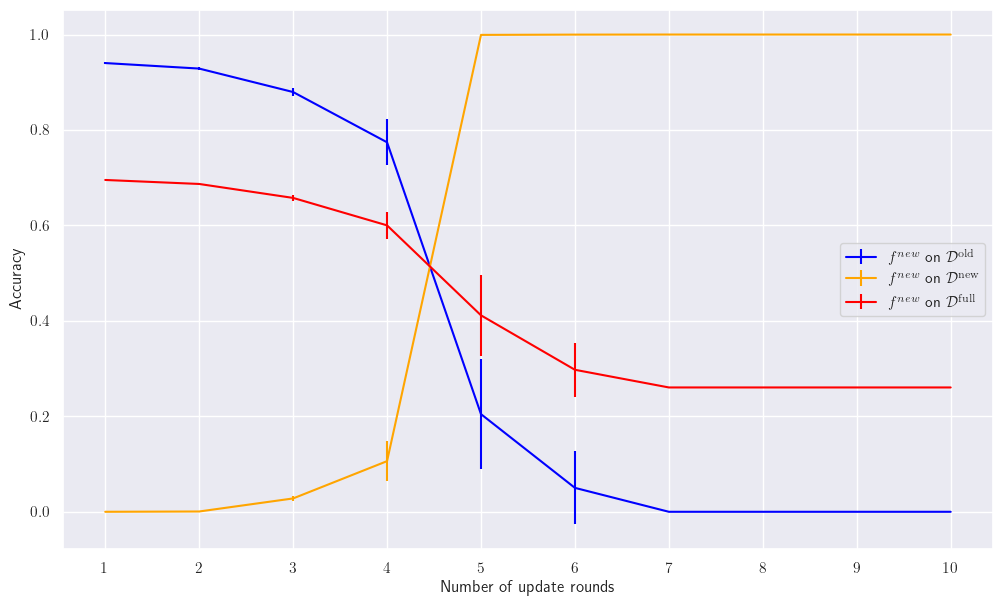

In [27]:
save = True

"""
Creates the plots from the results.
The argument largest_or_smallest_class should get passed a string, either 'largest class' or 'smallest class'.
This argument is inserted directly in the plot title.
"""

# create folder where the images are stored
Path('images').mkdir(parents=True, exist_ok=True)

# give it a name
images_folder = Path('images')


"""
# unpack the results that are stored in a dict further
old_data_mean = old_data_mean_results
old_data_std = old_data_std_results
new_data_mean = new_data_mean_results
new_data_std = new_data_std_results
update_data_mean = update_data_mean_results
update_data_std = update_data_std_results
full_data_mean = full_data_mean_results
full_data_std = full_data_std_results
"""

# in case I did the experiments with varying update rounds there will be multiple keys in each of the dicts
# the keys indicate the number of performed update rounds
# plot performances
fig = plt.figure(figsize=(12,7))
ax = plt.gca()
#ax.set_xlim([0, 1])
#ax.set_ylim([0.8, 1])

#ax.set_xlim([0, 1])
#ax.set_ylim([0, 1])

plot_title = 'catastrophic_forgetting_cont_training'
    
#plt.title(plot_title)

plt.errorbar(num_round_update,
             old_data_mean,
             yerr=old_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{old}}$",
             color='blue')

plt.errorbar(num_round_update,
             new_data_mean,
             yerr=new_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{new}}$",
             color='orange')

plt.errorbar(num_round_update,
             full_data_mean,
             yerr=full_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{full}}$",
             color='red')

plt.xlabel("Number of update rounds")
plt.xticks(num_round_update)
plt.ylabel("Accuracy")
plt.legend()

if save:
    filename = plot_title
    savepath = Path(images_folder / f'{filename}')
    plt.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show();

In [28]:
# these dictionaries are filled with the results and later pickled

old_data_mean_results = dict()
old_data_std_results = dict()
new_data_mean_results = dict()
new_data_std_results = dict()
full_data_mean_results = dict()
full_data_std_results = dict()

# the update routine
# initialize arrays where results are stored
old_data_mean = np.zeros(len(num_round_update))
old_data_std = np.zeros(len(num_round_update))
new_data_mean = np.zeros(len(num_round_update))
new_data_std = np.zeros(len(num_round_update))
full_data_mean = np.zeros(len(num_round_update))
full_data_std = np.zeros(len(num_round_update))

for num_round_update_idx, num_round_updt in enumerate(num_round_update):
    print(f"Current number of update rounds in use: {num_round_updt}")

    # initialize arrays where temporary results are stored
    old_data_tmp = np.zeros(num_models)
    new_data_tmp = np.zeros(num_models)
    full_data_tmp = np.zeros(num_models)

    for model_num in range(num_models):
        
        # training the original model
        
        seed = np.random.randint(0,100)
        # split original data into train- and test-data
        X_train_small, X_test_small, y_train_small, y_test_small = skl.model_selection.train_test_split(data_small, 
                                                                                                        labels_small,
                                                                                                        test_size=.2,
                                                                                                        random_state=seed)

        # specify DMatrices
        dtrain_small = xgb.DMatrix(X_train_small, label=y_train_small)
        dtest_small = xgb.DMatrix(X_test_small, label=y_test_small)
        
        evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]
        
        bst_small = xgb.train(param_small,
                              dtrain_small,
                              num_round,
                              evals=evallist_small,
                              verbose_eval=False)

        bst_small.save_model(fname=model_folder / 'small_model.json')
            
        # concatenate selected data with data of new class
        data_update = new_class_data
        labels_update = new_class_labels

        # use all the update data to update the model
        dtrain_update = xgb.DMatrix(data_update, label=labels_update)

        bst_update = add_class.add_class(model_file=model_folder/"small_model.json",
                                          data=data_update,
                                          labels=labels_update,
                                          num_tree_grps=num_round,
                                          num_orig_classes=num_labels,
                                          num_iterations=num_round_updt,
                                          params=param_update,
                                          weights=None)

        
        old_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dsmall), axis=1),
                                                               labels_small)
        new_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dnew_class), axis=1),
                                                               new_class_labels)
        full_data_tmp[model_num] = skl.metrics.accuracy_score(np.argmax(bst_update.predict(dfull), axis=1),
                                                                labels_full)

    old_data_mean[num_round_update_idx] = old_data_tmp.mean()
    old_data_std[num_round_update_idx] = old_data_tmp.std()
    new_data_mean[num_round_update_idx] = new_data_tmp.mean()
    new_data_std[num_round_update_idx] = new_data_tmp.std()  
    full_data_mean[num_round_update_idx] = full_data_tmp.mean()
    full_data_std[num_round_update_idx] = full_data_tmp.std()

Current number of update rounds in use: 1
Current number of update rounds in use: 2
Current number of update rounds in use: 3
Current number of update rounds in use: 4
Current number of update rounds in use: 5
Current number of update rounds in use: 6
Current number of update rounds in use: 7
Current number of update rounds in use: 8
Current number of update rounds in use: 9
Current number of update rounds in use: 10


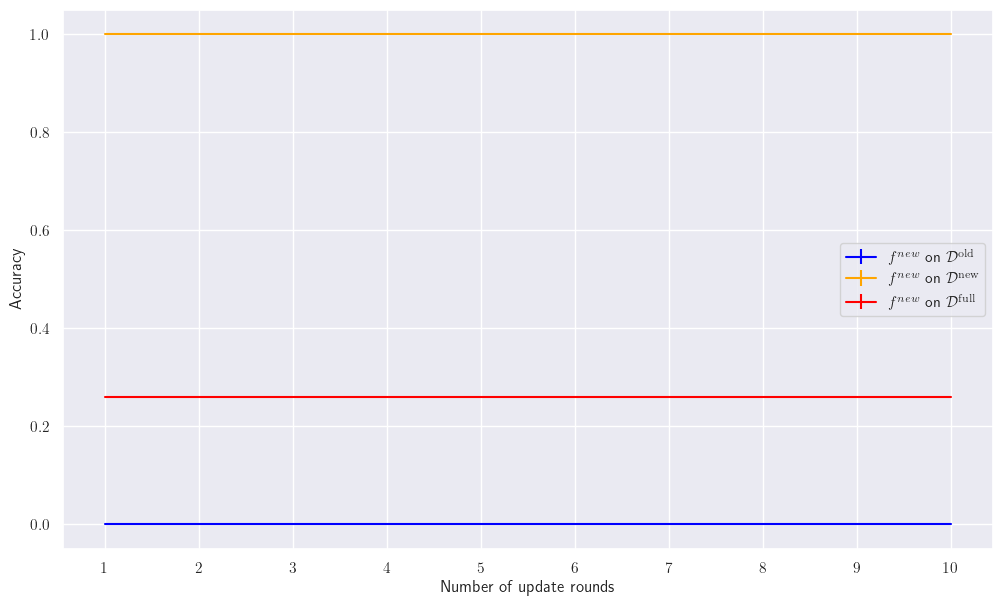

In [29]:
save = True

"""
Creates the plots from the results.
The argument largest_or_smallest_class should get passed a string, either 'largest class' or 'smallest class'.
This argument is inserted directly in the plot title.
"""

# create folder where the images are stored
Path('images').mkdir(parents=True, exist_ok=True)

# give it a name
images_folder = Path('images')


"""
# unpack the results that are stored in a dict further
old_data_mean = old_data_mean_results
old_data_std = old_data_std_results
new_data_mean = new_data_mean_results
new_data_std = new_data_std_results
update_data_mean = update_data_mean_results
update_data_std = update_data_std_results
full_data_mean = full_data_mean_results
full_data_std = full_data_std_results
"""

# in case I did the experiments with varying update rounds there will be multiple keys in each of the dicts
# the keys indicate the number of performed update rounds
# plot performances
fig = plt.figure(figsize=(12,7))
ax = plt.gca()
#ax.set_xlim([0, 1])
#ax.set_ylim([0.8, 1])

#ax.set_xlim([0, 1])
#ax.set_ylim([0, 1])

plot_title = 'catastrophic_forgetting_add_trees'
    
#plt.title(plot_title)

plt.errorbar(num_round_update,
             old_data_mean,
             yerr=old_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{old}}$",
             color='blue')

plt.errorbar(num_round_update,
             new_data_mean,
             yerr=new_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{new}}$",
             color='orange')

plt.errorbar(num_round_update,
             full_data_mean,
             yerr=full_data_std,
             label="$f^{new}$ on $\mathcal{D}^{\mathrm{full}}$",
             color='red')

plt.xlabel("Number of update rounds")
plt.xticks(num_round_update)
plt.ylabel("Accuracy")
plt.legend()

if save:
    filename = plot_title
    savepath = Path(images_folder / f'{filename}')
    plt.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show();